In [1]:
# Don't blame me
#           -Kai
#
# github.com/kaibrooks
#
# all paths displayed here are relative to the Docker environment filesystem
# by default, /tf/notebooks/ maps to the local dir used in the Docker run command

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
# use tensorflow and keras as a high-level api to make it faster to get something running
import tensorflow as tf
import threading
import scipy
import PIL # this imports Pillow, but for some dumb reason needs 'PIL'
from PIL import Image
from tensorflow import keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from datetime import datetime # so we know how much time we've wasted
import matplotlib.pyplot as plt # fancy plots

import numpy as np
import matplotlib.pyplot as plt # plot things

import os

# might be good to know

print('TensorFlow version', tf.__version__)
print('Keras version', keras.__version__)
print('SciPy version', scipy.__version__)
print('Numpy version', np.__version__) 
print('Pillow version', PIL.__version__) 


try:
  # %tensorflow_version only exists in google colab, see if we can use it or not
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow version 2.0.0
Keras version 2.2.4-tf
SciPy version 1.3.3
Numpy version 1.17.4
Pillow version 6.2.1


In [3]:
## all the settings, this section is the secret sauce
# hyperparameters
batch_size = 16  # 16?
num_classes = 3 # how many classes we're detecting
epochs = 5 # 100
num_predictions = 20 # 20
learning_rate = 0.0001 #0.0001
decay = 1e-6 # 1e-6

# sub-parameters
use_multiprocessing = False # F parallelize or not
workers = 1 # 1 workers to use for training

# other settings
data_augmentation = False # T make permutations to train better
threadSafe = False # F make thread safe, sometimes produces errors
fastTrain = False # F 3x less time, 0.75x as accurate ish

# output
save_dir = os.path.join(os.getcwd(), 'trained_models')
#model_name = 'keras_trained_model_' + now.strftime("%d-%b-%Y_%H:%M:%S") + '.h5' # this is below


In [4]:
## load the data

print('Getting data from', os.getcwd())
datagen = ImageDataGenerator(rescale = 1. / 255) # rescale images to squares for display

# load and iterate training dataset
print('Train: ')
train_it = datagen.flow_from_directory('data/train/', class_mode='categorical', batch_size=batch_size)

# load and iterate validation dataset
print('Validate: ')
val_it = datagen.flow_from_directory('data/validation/', class_mode='categorical', batch_size=batch_size)

# load and iterate test dataset
print('Test:')
test_it = datagen.flow_from_directory('data/test/', class_mode='categorical', batch_size=batch_size)



Getting data from /tf/notebooks
Train: 
Found 1280 images belonging to 3 classes.
Validate: 
Found 128 images belonging to 3 classes.
Test:
Found 67 images belonging to 3 classes.


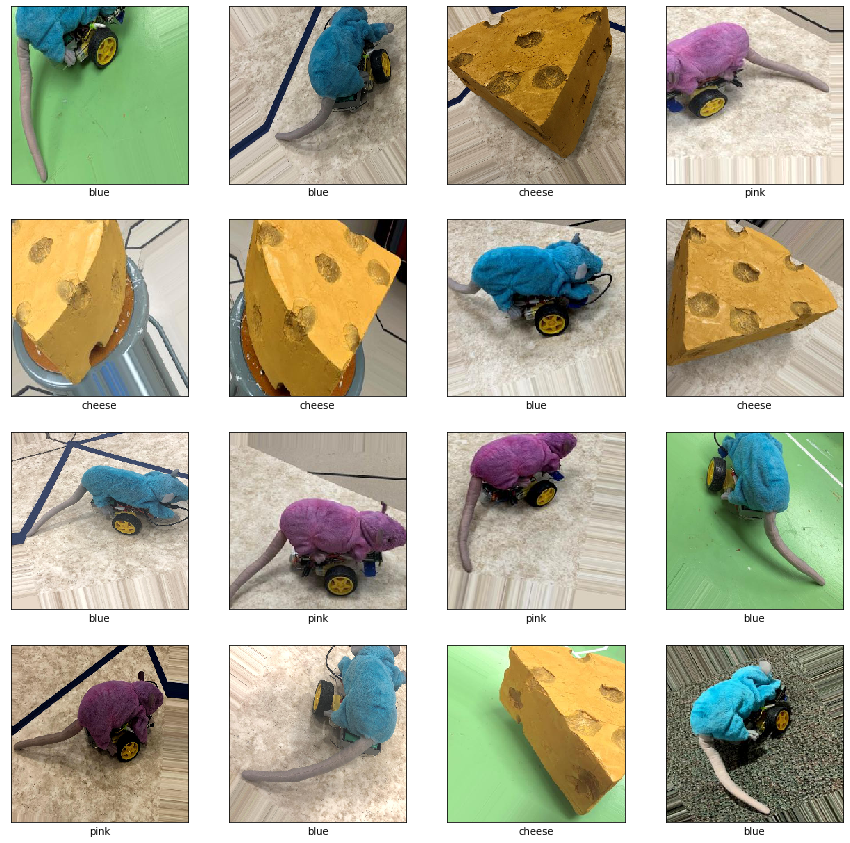

We're almost at the training step. If this image isn't 100% correct the entire training will be a waste


In [5]:
class_names = ['blue','cheese','pink']
(train_images, train_labels) = train_it.next()
plt.figure(figsize=(15,15))
for i in range(batch_size):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(train_labels[i])]) # int because class number is normally a float
    #plt.xlabel(train_labels[i])
plt.show()
print('We\'re almost at the training step. If this image isn\'t 100% correct the entire training will be a waste')

In [6]:
# set up model
if fastTrain:
    print('Using fast training algorithm, model will be less accurate')
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes)) # convergence layer
    model.add(Activation('softmax'))
    
elif not fastTrain:
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=train_images.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes)) # convergence layer
    model.add(Activation('softmax'))
else: pass

if fastTrain: print('Using fast algorithm, output will be less accurate')
print('Model in the chamber:', model)
print('Ready to train')

Model in the chamber: <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f86757087b8>
Ready to train


In [7]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=learning_rate, decay=decay)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255



# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
#datagen.fit(x_train)

now = datetime.now()
print("Starting training at", now.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this takes



# fit model
history = model.fit_generator(train_it, 
                    epochs=epochs, 
#                    steps_per_epoch=16, 
                    validation_data=val_it, 
                    validation_steps=8,
                    workers=workers)



(x_test, y_test) = val_it.next()
# Fit the model on the batches generated by datagen.flow().
#model.fit_generator(datagen.flow(train_images, train_labels,
#                    batch_size=batch_size),
#                    epochs=epochs,
#                    validation_data=(x_test, y_test),
#                    use_multiprocessing=use_multiprocessing,
#                    max_queue_size=10,
#                    workers=workers) # workers = 1 or 4?



then = datetime.now()
print("Finished training at", then.strftime("%d-%b-%Y %H:%M:%S")) # lets see how long this took

print('Model summary:')
model.summary()

Starting training at 29-Nov-2019 20:26:01
Epoch 1/5
80/80 [==============================] - 432s 5s/step - loss: 0.7456 - accuracy: 0.8344 - val_loss: 0.0837 - val_accuracy: 1.0000
Epoch 2/5
80/80 [==============================] - 410s 5s/step - loss: 0.0482 - accuracy: 0.9828 - val_loss: 0.0402 - val_accuracy: 1.0000
Epoch 3/5
80/80 [==============================] - 401s 5s/step - loss: 0.0216 - accuracy: 0.9945 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 4/5
80/80 [==============================] - 399s 5s/step - loss: 0.0082 - accuracy: 0.9969 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 5/5
80/80 [==============================] - 402s 5s/step - loss: 0.0063 - accuracy: 0.9977 - val_loss: 0.0042 - val_accuracy: 1.0000
Finished training at 29-Nov-2019 21:00:04
Model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)

In [10]:
## save model log
# this is where you pay attention to where you mapped the Docker dir to your local dir at run

if not os.path.isdir(save_dir): # make dir if it doesn't exist
    os.makedirs(save_dir)    
    print(save_dir, 'doesn\'t exist, creating it')

print('Saving...') # do this because saving the model takes 5+ seconds sometimes

# 
model_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_trainedmodel.h5'
summary_name = now.strftime("%Y-%m-%d_%H-%M-%S") + '_modelsummary.txt'

# save summary
with open(os.path.join(save_dir, summary_name),'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

# save model
model_path = os.path.join(save_dir, model_name)
model.save(model_path)

#model_path = os.path.join(save_dir, summary_name)
#print(model_path)
#model.save(model_path)
  
print('Saved trained model at %s ' % model_path)
print('Saved training summary at %s' % model_path)   

size = os.path.getsize(model_path) # note how big the model is because they're often huge
print('Model is',round(size/1e+6),'MB')

/tf/notebooks/trained_models doesn't exist, creating it
Saving...
Saved trained model at /tf/notebooks/trained_models/2019-11-29_20-26-01_trainedmodel.h5 
Saved training summary at /tf/notebooks/trained_models/2019-11-29_20-26-01_trainedmodel.h5
Model is 1008 MB


In [11]:
## score trained model
(test_images, test_labels) = test_it.next()
scores = model.evaluate(test_images, test_labels, verbose=2)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

16/1 - 1s - loss: 0.7700 - accuracy: 0.7500
Test loss: 0.7699767351150513
Test accuracy: 0.75


In [12]:
## make a predictions
predictions = model.predict(test_images) # load the data
predictions[0] # predict the [0]th element, this outputs an array with each element being the confidence of being that class
print('Class confidence for image 0:', predictions[0])
print('\nPrediction  :', np.argmax(predictions[0])) # output the most likely prediction
print('Actual class:', np.argmax(test_labels))  # output what the answer actually is)

Class confidence for image 0: [0.35315028 0.07303163 0.5738181 ]

Prediction  : 2
Actual class: 2


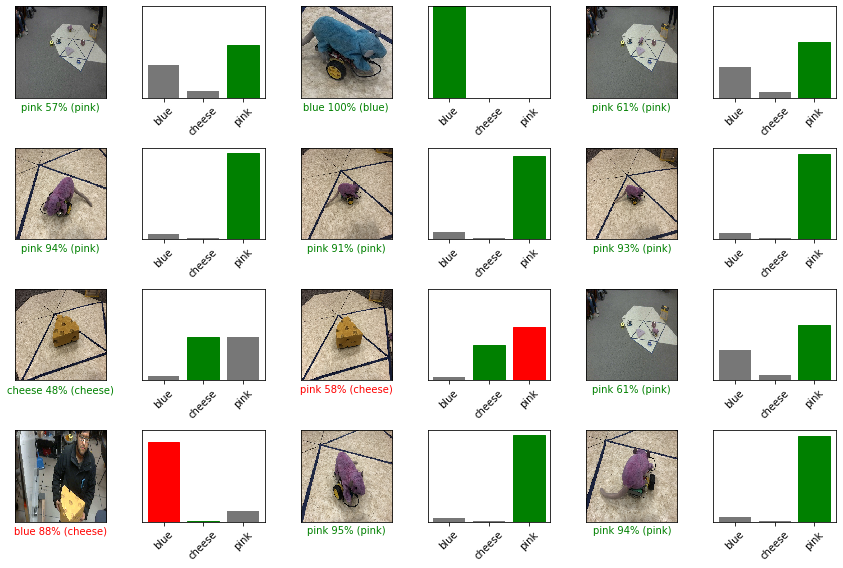

In [13]:
## make a pinterest board of images and their classifications
# set up first
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, np.argmax(true_label[i])
  plt.grid(False)
  plt.xticks(range(len(class_names)))
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[int(true_label)].set_color('green')

## plot a single image and its prediction
#i = 0
#plt.figure(figsize=(6,3))
#plt.subplot(1,2,1)
#plot_image(i, predictions[i], test_labels, test_images)
#plt.subplot(1,2,2)
#plot_value_array(i, predictions[i],  test_labels)
#plt.show()

# lets do another
#i = 12
#plt.figure(figsize=(6,3))
#plt.subplot(1,2,1)
#plot_image(i, predictions[i], test_labels, test_images)
#plt.subplot(1,2,2)
#plot_value_array(i, predictions[i],  test_labels)
#plt.show()

## show a bunch of predicted images and display a grid
num_rows = 4 # increase this to show more
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
  _ = plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.tight_layout()
plt.show()

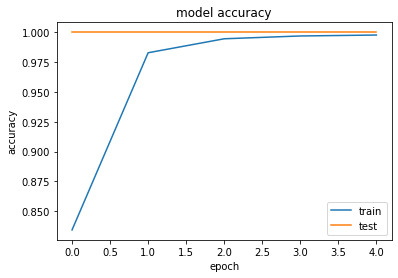

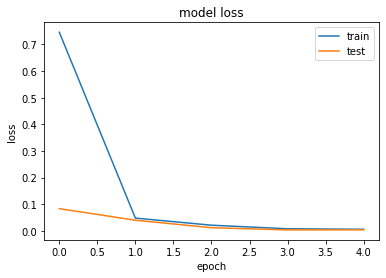

In [14]:
## plot accuracy
plt.plot(history.history['accuracy']) # kx or similar Matlab commands for plotting
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# plot history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()